# **Trashnet Model Classification**

## 1. Import necessary library

In [1]:
# import library
import os
import cv2
import wandb
import zipfile
import itertools
import numpy as np
from PIL import Image
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.regularizers import l2 
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Flatten, BatchNormalization, Activation
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report,confusion_matrix

## 2. Connect the project to wandb.ai

Token = e6b560f231ce4340b0f25babee88ab03bd921db8

In [2]:
# connect to wandb.ai
wandb.init(project="trashnet-model", entity="azizbp-gunadarma-university")

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


## 3. Import the dataset from huggingface website

In [3]:
# clone dataset to notebook
!git clone https://huggingface.co/datasets/garythung/trashnet

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Cloning into 'trashnet'...
remote: Enumerating objects: 11, done.
remote: Total 11 (delta 0), reused 0 (delta 0), pack-reused 11 (from 1)
Unpacking objects: 100% (11/11), 1.97 KiB | 671.00 KiB/s, done.


## 4. Unzip the dataset
Since the dataset is still zipped, you need to unzip before using it. 

I also have tried to do training with original dataset, it really takes long time to do the training. Because the size of original dataset is too big. So, I decided to use the resized dataset

In [4]:
# unzip the dataset
zip_file_path = '/kaggle/working/trashnet/dataset-resized.zip'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall()

os.listdir('dataset-resized')

['metal', '.DS_Store', 'paper', 'plastic', 'glass', 'trash', 'cardboard']

Inside the dataset folder is still any .DS_Store file that can disturb the classes of dataset, so I decided to remove it

In [5]:
# remove the .DS_Store file
ds_store_path = '/kaggle/working/dataset-resized/.DS_Store'

if os.path.exists(ds_store_path):
    os.remove(ds_store_path)
    print(".DS_Store file removed successfully.")
else:
    print(".DS_Store file does not exist.")

.DS_Store file removed successfully.


## 5. Initialize the directory 
Firstly, I intialize the directory and list the classes

In [6]:
# intialize the directory and see classes
train_dir = '/kaggle/working/dataset-resized'
classes = os.listdir(train_dir)
print(classes)

['metal', 'paper', 'plastic', 'glass', 'trash', 'cardboard']


## 6. Exploratory Image Analysis
I decided to do exploratory the images first, to see what is the dataset look like. So far, I didn't see the blur images or corrupted images. I also have checked it manually on my local. Next, we will check the distribution of the dataset.

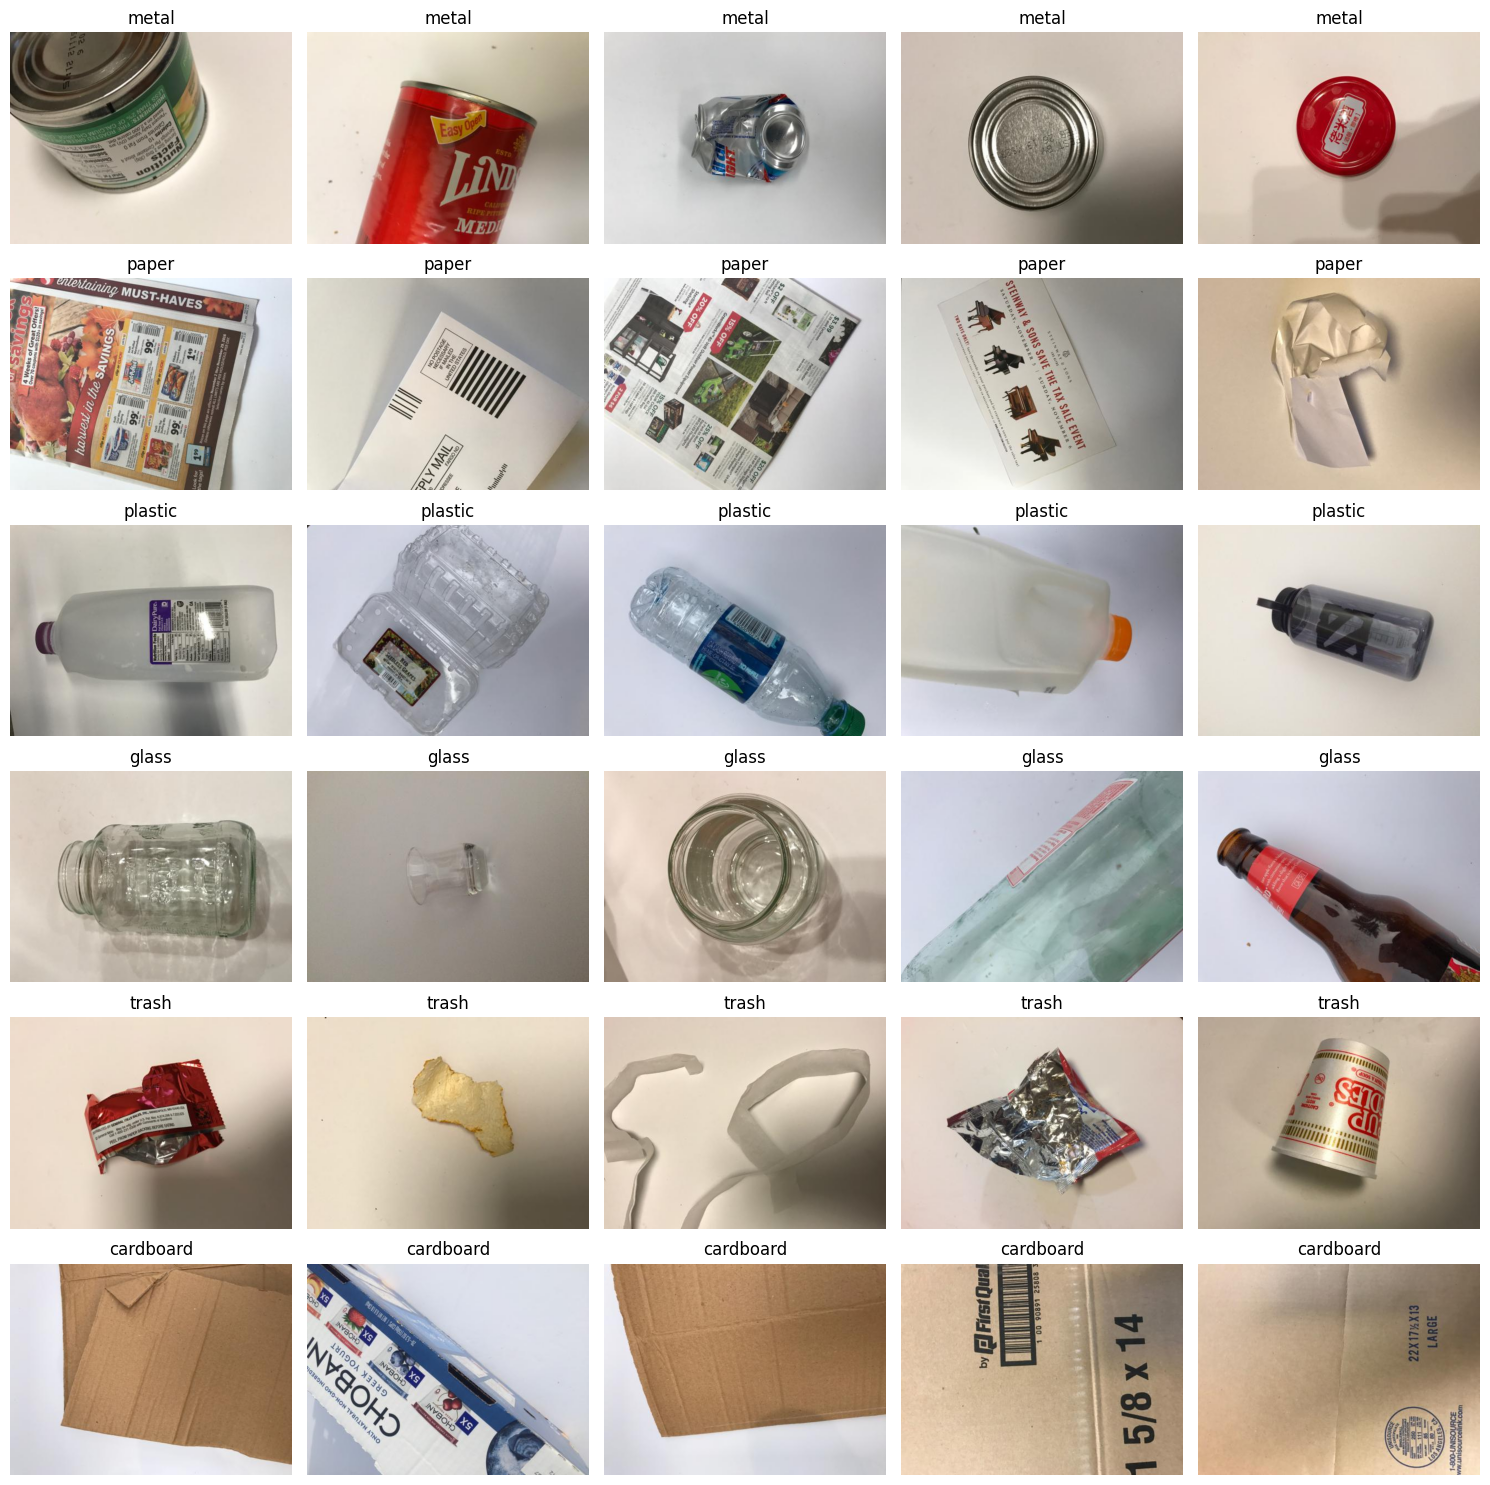

In [7]:
## display images to do EIA (Exploratory Image Analysis)
def display_sample_images(classes, train_dir, num_samples=5):
    plt.figure(figsize=(15, 15))
    
    for i, class_name in enumerate(classes):
        class_dir = os.path.join(train_dir, class_name)
        images = os.listdir(class_dir)[:num_samples]
        
        for j, img in enumerate(images):
            img_path = os.path.join(class_dir, img)
            img_obj = Image.open(img_path)
            
            plt.subplot(len(classes), num_samples, i * num_samples + j + 1)
            plt.imshow(img_obj)
            plt.title(class_name)
            plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
display_sample_images(classes, train_dir, num_samples=5)

Check the distribution of the dataset

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


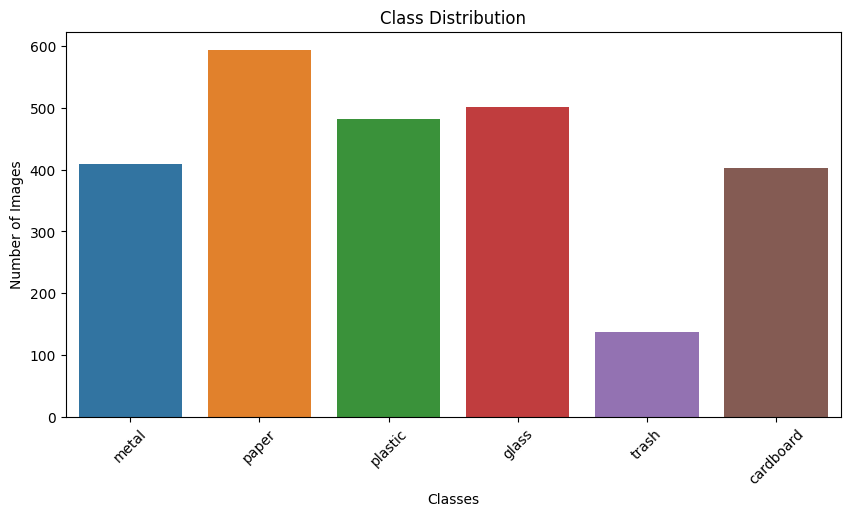

In [8]:
# check the distribution of the dataset
class_counts = {class_name: len(os.listdir(os.path.join(train_dir, class_name))) for class_name in classes}

plt.figure(figsize=(10, 5))
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))
plt.title('Class Distribution')
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.show()

As, we can see the dataset is imbalanced. I have an idea to balanced them with oversampling or undersampling.
But, It has pros and cons.

1. Oversampling

Pros : keep the original data, and not discarding data

Cons : too much duplication on minor class, like trash

2. Undersampling

Pros : keep the dataset manageable, potentially reduces overfitting on minor class, like trash

Cons : miss a lot of data, that can degrade the quality of model


First, I decided to oversampling trash class with augmentation until 400 images. Why I choose this? Because it is the simple way to oversampling the trash class with python script. And I want my model is can be reproduced by people that access my notebook. So, they don't need oversampling manually and can just run the cell below to do oversampling the trash class with augmentation. But, the problem is the model is bias to trash class, because I try to oversampling with just 1 image. Even if with the all images was being augmented, the model is overfitting.

Then, I found new way to overcome imbalanced dataset. I tried to use class weights. Class weights assign weights to minority classes and lower weights to majority classes. So, it can minimized bias to majority class.

In [9]:
# using class weights
total_samples = sum([len(os.listdir(os.path.join(train_dir, class_name))) 
                    for class_name in ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']])
class_weights = {
    0: total_samples / (6 * len(os.listdir(os.path.join(train_dir, 'cardboard')))),
    1: total_samples / (6 * len(os.listdir(os.path.join(train_dir, 'glass')))),
    2: total_samples / (6 * len(os.listdir(os.path.join(train_dir, 'metal')))),
    3: total_samples / (6 * len(os.listdir(os.path.join(train_dir, 'paper')))),
    4: total_samples / (6 * len(os.listdir(os.path.join(train_dir, 'plastic')))),
    5: total_samples / (6 * len(os.listdir(os.path.join(train_dir, 'trash'))))
}

Then, I split the dataset 80% for train and 20% for validation and augmentating the dataset.

In [10]:
# augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=45,
    width_shift_range=0.3,
    height_shift_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    shear_range=0.3,
    zoom_range=0.3,
    brightness_range=[0.7, 1.3],
    fill_mode='nearest',
    validation_split=0.2
)

val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

In [11]:
# generator
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical',
        shuffle=True,
        subset='training'
)

validation_generator = val_datagen.flow_from_directory(
        train_dir,
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical',
        shuffle=False,
        subset='validation'
)

Found 2024 images belonging to 6 classes.
Found 503 images belonging to 6 classes.


## 7. Define The Layer

For the beginning, I will try build the CNN layer from scratch. Then I try with VGG19, then MobileNetV2.
1. Scratch

Pros : can explore with many layers

Cons : take a much time to explore


2. VGG19 

Pros : easy and common to use it

Cons : Too big size, take a long time to train


3. MobilenetV2

Pros : light size of layers and model

Cons : can't get the accuracy that I want, cause I think the dataset is too complex


4. DenseNet121

Pros : light enough size

Cons : take a long time to train, cause a lot of layers. But, I outsmarted it with adjusted the learning rate and use class weight


In [12]:
# base model DenseNet121
base_model = DenseNet121(input_shape=(224, 224, 3),
                         include_top=False,
                         weights='imagenet')

for layer in base_model.layers[:-30]:
    layer.trainable = False

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [13]:
# several additions to layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(256, kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(6, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 7,306,566 (27.87 MB)

 Trainable params: 907,910 (3.46 MB)

 Non-trainable params: 6,398,656 (24.41 MB)

In [14]:
# compile model
optimizer = Adam(learning_rate=0.001)

model.compile(loss = 'categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

## 8. Setup config
Setup config before training. I used with wandb config to track, lr reduction to adjust the lr, and early stopping callback.

In [15]:
# setup config epoch, lr and batch size
config = {
    "learning_rate": 0.001,
    "epochs": 50,
    "batch_size": 32
}

wandb.config.update(config)

In [16]:
# try to reduction the lr
lr_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                 patience=2, 
                                 factor=0.2,
                                 min_lr=1e-7,
                                 verbose=1)

In [17]:
# early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

In [18]:
# define callback
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if (logs.get('accuracy') > 0.9) and (logs.get('val_accuracy') > 0.9) :
            self.model.stop_training = True

callbacks = [myCallback(), early_stopping, lr_reduction]

## 9. Training

In [19]:
# begin training
history = model.fit(train_generator, 
                    validation_data=validation_generator, 
                    batch_size=["batch_size"], 
                    epochs=config["epochs"],
                    class_weight=class_weights,
                    verbose=1,
                    callbacks=callbacks
                    )

Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1730099204.532635     188 service.cc:145] XLA service 0x7de2b0095030 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730099204.532697     188 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1730099204.532701     188 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


 1/64 ━━━━━━━━━━━━━━━━━━━━ 43:13 41s/step - accuracy: 0.1250 - loss: 6.0966

I0000 00:00:1730099225.701899     188 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


64/64 ━━━━━━━━━━━━━━━━━━━━ 103s 989ms/step - accuracy: 0.4073 - loss: 5.0505 - val_accuracy: 0.6918 - val_loss: 3.1266 - learning_rate: 0.0010
Epoch 2/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 27s 383ms/step - accuracy: 0.7056 - loss: 2.8568 - val_accuracy: 0.7594 - val_loss: 2.4082 - learning_rate: 0.0010
Epoch 3/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 27s 381ms/step - accuracy: 0.7448 - loss: 2.2954 - val_accuracy: 0.8072 - val_loss: 1.9878 - learning_rate: 0.0010
Epoch 4/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 27s 387ms/step - accuracy: 0.8015 - loss: 1.8982 - val_accuracy: 0.7853 - val_loss: 1.8543 - learning_rate: 0.0010
Epoch 5/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 27s 383ms/step - accuracy: 0.8162 - loss: 1.5768 - val_accuracy: 0.7654 - val_loss: 1.6467 - learning_rate: 0.0010
Epoch 6/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 28s 387ms/step - accuracy: 0.8124 - loss: 1.4194 - val_accuracy: 0.8072 - val_loss: 1.3219 - learning_rate: 0.0010
Epoch 7/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 28s 385ms/step - accuracy: 0.8248 - loss: 1.2321 - val

In [20]:
# save epoch in wandb
for epoch in range(config["epochs"]):

    wandb.log({
        "epoch": epoch + 1,
        "accuracy": 'accuracy',
        "loss": 'loss',
        "val_accuracy": 'val_accuracy',
        "val_loss": 'val_loss'
    })


## 10. Training and Validation Accuracy and Loss Display

As we can see, the accuracy is great when move up, also same with validation. The loss also move down as the epochs increase. However the loss train and validation is not good enough, as we get 0.3 train loss and 0.6 loss validation. But that's already good with the size of model that we got

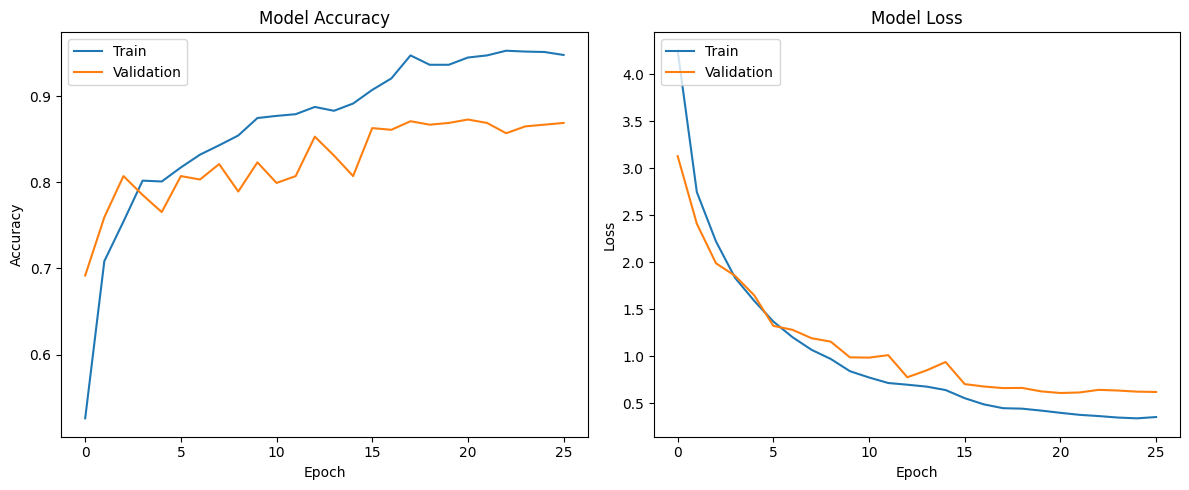

In [21]:
plt.figure(figsize=(12, 5))

# accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

## 11. Classification Report

The precision, recall and f1-score is already good enough except for the trash class. Because this is the issue of the dataset, the trash class is minority. Though we have done with class weight, but it can't be above 0.8.

In [22]:
preds = model.predict(validation_generator, steps=validation_generator.samples // validation_generator.batch_size + 1)
y_pred = np.argmax(preds, axis=1)

# True labels
y_true = validation_generator.classes

# Class indices
class_indices = validation_generator.class_indices
class_labels = list(class_indices.keys())

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

16/16 ━━━━━━━━━━━━━━━━━━━━ 17s 584ms/step
Classification Report:
              precision    recall  f1-score   support

   cardboard       0.97      0.79      0.87        80
       glass       0.95      0.90      0.92       100
       metal       0.79      0.93      0.85        82
       paper       0.87      0.95      0.91       118
     plastic       0.88      0.81      0.84        96
       trash       0.69      0.74      0.71        27

    accuracy                           0.87       503
   macro avg       0.86      0.85      0.85       503
weighted avg       0.88      0.87      0.87       503



## 12. Confusion Matrix

The prediction from validation also good enough, like near 90%. The model can predicted it accurately

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step


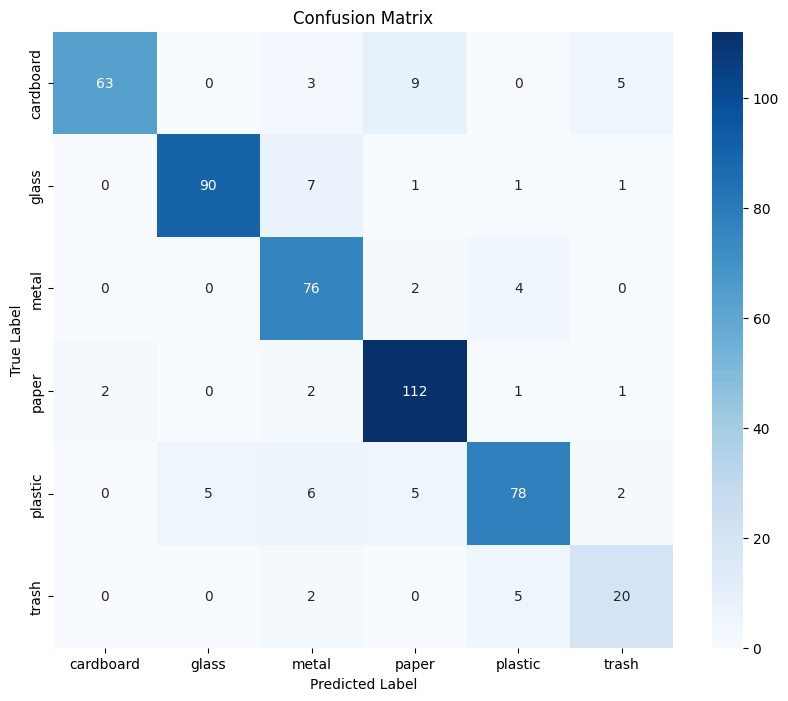

In [23]:
preds = model.predict(validation_generator, steps=validation_generator.samples // validation_generator.batch_size + 1)
y_pred = np.argmax(preds, axis=1)

y_true = validation_generator.classes

conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

## 13. Save Model

In [24]:
model.save('bestModel-trashnet_v9-densenet121.h5')

## 14. Save Artifact in wandb.ai and finish

In [25]:
artifact = wandb.Artifact("trashnet-model", type="model")
artifact.add_file("bestModel-trashnet_v9-densenet121.h5")
wandb.log_artifact(artifact)

<Artifact trashnet-model>

In [26]:
wandb.finish()

epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
accuracy,accuracy
epoch,50
loss,loss
val_accuracy,val_accuracy
val_loss,val_loss
